Summary of approach and findings:

Conclusion:  
The user table is adequate to make good predictions about who will be an active user. A tuned Random Forest model with 11 features can make predictions with  64% precision and 74% recall. Note that the data is heavily imbalanced with only about 10% of user active users.

The most important feature by far was last session creation time. The next two important featuers were features that I created, org id counts and invitation id counts. Org id counts measures how many times an org is associated with a user. So if a user has a org id with a high count, then they have a popular org. Invitation id count is similar, where invitation id is the id of the second user that invited the user.

Features:  
I dropped name and email address as these are likely not predictive. Last session creation time was converted to a number measuring time past the minimum number which was set to zero. Creation source was converted into dummy variables. Other categorical features were already binary so did not need to be converted to dummies. Org id and invited by user id were converted to value counts and dropped as described above.

Finally creation time is a feature that could be predictive, however, the model was not accepting the datatype, so I dropped it.

Improvements:  
The model could be improved by including creation time. Also, the top org ids and invited by user ids (say the top 3 of each) could be included as dummy variables, with the idea that certain individuals or orgs could be good at attracting or inviting active users.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta


In [2]:
# import Random Forests Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
from sklearn.metrics import auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,log_loss


In [4]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [5]:
users = pd.read_csv('takehome_users.csv', index_col='object_id')


In [6]:
users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [7]:
users.creation_time = pd.to_datetime(users.creation_time)

In [112]:
users.creation_time.min(), users.creation_time.max()

(Timestamp('2012-05-31 00:43:27'), Timestamp('2014-05-30 23:59:19'))

In [8]:
start = users.last_session_creation_time.min()
users.last_session_creation_time = users.last_session_creation_time-start

In [9]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   name                        12000 non-null  object        
 2   email                       12000 non-null  object        
 3   creation_source             12000 non-null  object        
 4   last_session_creation_time  8823 non-null   float64       
 5   opted_in_to_mailing_list    12000 non-null  int64         
 6   enabled_for_marketing_drip  12000 non-null  int64         
 7   org_id                      12000 non-null  int64         
 8   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 937.5+ KB


In [56]:
users.opted_in_to_mailing_list = users.opted_in_to_mailing_list.astype('object')
users.enabled_for_marketing_drip = users.enabled_for_marketing_drip.astype('object')

In [57]:
users.nunique()

creation_time                 11996
creation_source                   5
last_session_creation_time     8821
opted_in_to_mailing_list          2
enabled_for_marketing_drip        2
org_id                          417
invited_by_user_id             2565
org_id_counts                    75
invited_id_counts                14
dtype: int64

keep:  
 0   creation_time               12000 non-null  datetime  
 3   creation_source             12000 non-null  object          
 4   last_session_creation_time  8823 non-null   float64         
 5   opted_in_to_mailing_list    12000 non-null  int64           
 6   enabled_for_marketing_drip  12000 non-null  int64           
 7   org_id                      12000 non-null  int64           
 8   invited_by_user_id          6417 non-null   float64  

drop:  
 1   name                        12000 non-null  object          
 2   email                       12000 non-null  object          


In [52]:
users = users.drop(['name','email'],axis=1)

In [17]:
org_id_vc = users.org_id.value_counts()

In [15]:
org_id_dict = org_id.to_dict()

In [21]:
users['org_id_counts']=0

In [22]:
for i in users.index:
    users.loc[i,'org_id_counts'] = org_id_dict[users.loc[i,'org_id']]

In [28]:
users[['org_id','org_id_counts']].loc[1:5]

,org_id,org_id_counts
object_id,,
1,11,75
2,1,233
3,94,32
4,1,233
5,193,16


In [38]:
# range of ids in this column
users.invited_by_user_id.value_counts().index.min(), users.invited_by_user_id.value_counts().index.max()

(3.0, 11999.0)

In [41]:
# above cell shows that 0 is available for fillna
# 0 represents anyone who was not invited by a user
users.invited_by_user_id = users.invited_by_user_id.fillna(0)


In [42]:
invited_id_vc = users.invited_by_user_id.value_counts()

In [43]:
invited_id_vc_dict = invited_id_vc.to_dict()

In [44]:
# number of users who were not invited by anyone
invited_id_vc_dict[0]

5583

In [45]:
# initialize column for counts
users['invited_id_counts']=0

In [46]:
for i in users.index:
    users.loc[i,'invited_id_counts'] = invited_id_vc_dict[users.loc[i,'invited_by_user_id']]

In [51]:
invited_id_vc_dict[1525]

11

In [48]:
users[['invited_by_user_id','invited_id_counts']][1:5]

,invited_by_user_id,invited_id_counts
object_id,,
2,316.0,3
3,1525.0,11
4,5151.0,7
5,5240.0,5


In [ ]:
users['adopted_user']=False

In [58]:
users.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,org_id_counts,invited_id_counts
object_id,,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,59686404.0,1,0,11,10803.0,75,1
2,2013-11-15 03:45:04,ORG_INVITE,57785098.0,0,0,1,316.0,233,3
3,2013-03-19 23:14:52,ORG_INVITE,25282486.0,0,0,94,1525.0,32,11
4,2013-05-21 08:09:28,GUEST_INVITE,30757762.0,0,0,1,5151.0,233,7
5,2013-01-17 10:14:20,GUEST_INVITE,20397254.0,0,0,193,5240.0,16,5


In [59]:
users = users.drop(['org_id','invited_by_user_id'],axis=1)

In [60]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   creation_source             12000 non-null  object        
 2   last_session_creation_time  8823 non-null   float64       
 3   opted_in_to_mailing_list    12000 non-null  object        
 4   enabled_for_marketing_drip  12000 non-null  object        
 5   org_id_counts               12000 non-null  int64         
 6   invited_id_counts           12000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 1008.0+ KB


In [61]:
engage = pd.read_csv('takehome_user_engagement.csv',parse_dates=True, index_col='time_stamp').sort_values(by='time_stamp')

In [62]:
users.shape, engage.shape

((12000, 7), (207917, 2))

In [63]:
engage.head()

,user_id,visited
time_stamp,,
2012-05-31 08:20:06,10012,1
2012-05-31 15:47:36,3428,1
2012-05-31 17:19:37,9899,1
2012-05-31 21:58:33,1693,1
2012-06-01 00:17:30,6102,1


In [70]:
# determine adopted users
users['adopted_user']=False
count = 0
for user in range(len(users)):
    df = engage.loc[engage.user_id==user]
    df.resample('d').min()   
    delta = timedelta(days=7)
    for i in range(len(df)):
        start_date = df.index[i]
        end_date = df.index[i]+delta
        if len(df.loc[start_date:end_date])>=3:
            users.loc[user,'adopted_user']=True
            count +=1
            break
print(count)

1656


In [65]:
users[users['adopted_user']==True][5:10]

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id_counts,invited_id_counts,adopted_user
object_id,,,,,,,,
43,2012-12-31 07:13:17,GUEST_INVITE,27557591.0,0,0,38,3,True
50,2012-06-03 11:02:08,GUEST_INVITE,12537722.0,0,0,40,7,True
53,2013-02-09 23:47:15,GUEST_INVITE,29345229.0,0,0,44,7,True
60,2014-03-21 22:56:03,ORG_INVITE,61742157.0,0,0,42,1,True
63,2012-12-20 16:30:52,SIGNUP_GOOGLE_AUTH,63447046.0,0,0,24,5583,True


In [71]:
# the adopted_user feature is very unbalanced. makes modeling difficult 

users.adopted_user.value_counts()

False    10344
True      1656
Name: adopted_user, dtype: int64

In [72]:
users.groupby('adopted_user').mean()['last_session_creation_time']

adopted_user
False    3.714341e+07
True     5.676868e+07
Name: last_session_creation_time, dtype: float64

In [74]:
users.last_session_creation_time.median()

44436064.0

<AxesSubplot:>

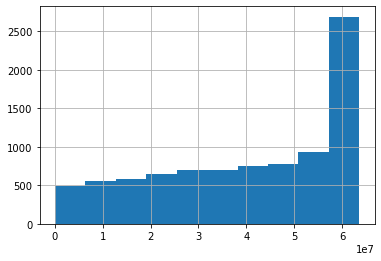

In [79]:
users.last_session_creation_time.hist()

Every user has NaN for 'last session creation time' is not an adopted user! Set Nan to -1 and model should capture all of them.

In [88]:
users[users['last_session_creation_time'].isnull()].groupby('adopted_user').count()


,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id_counts,invited_id_counts
adopted_user,,,,,,,
False,3177,3177,0,3177,3177,3177,3177


In [90]:
users.last_session_creation_time.fillna(-1, inplace=True)

No nulls!

In [91]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   creation_source             12000 non-null  object        
 2   last_session_creation_time  12000 non-null  float64       
 3   opted_in_to_mailing_list    12000 non-null  object        
 4   enabled_for_marketing_drip  12000 non-null  object        
 5   org_id_counts               12000 non-null  int64         
 6   invited_id_counts           12000 non-null  int64         
 7   adopted_user                12000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 1019.8+ KB


In [92]:
users_dum = pd.get_dummies(users, drop_first=True)

In [94]:
# 11 features
len(users_dum.columns), users_dum.columns

(11,
 Index(['creation_time', 'last_session_creation_time', 'org_id_counts',
        'invited_id_counts', 'adopted_user', 'creation_source_ORG_INVITE',
        'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
        'creation_source_SIGNUP_GOOGLE_AUTH', 'opted_in_to_mailing_list_1',
        'enabled_for_marketing_drip_1'],
       dtype='object'))

Define X and y

In [113]:
X = users_dum.drop(['adopted_user','creation_time'], axis=1)
y = users_dum['adopted_user']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
clf = RandomForestClassifier(
    class_weight='balanced', 
    max_features='sqrt', 
    n_estimators=300, random_state = 123, n_jobs=-1)

In [115]:
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]

ac = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Test Accuracy=%.3f' % (ac))
print('Random Forest: Test Precision=%.3f' % (prec))
print('Random Forest: Test Recall=%.3f' % (rec))
print(cm)
y_pred_train = model_res.predict(X_train)
train_ac = accuracy_score(y_train, y_pred_train)
train_rec = recall_score(y_train, y_pred_train)
train_prec = precision_score(y_train, y_pred_train)
print('Random Forest: Train Accuracy=%.3f' % (train_ac))
print('Random Forest: Train Precision=%.3f' % (train_prec))
print('Random Forest: Train Recall=%.3f' % (train_rec))


Random Forest: Test Accuracy=0.903
Random Forest: Test Precision=0.687
Random Forest: Test Recall=0.573
[[1975   88]
 [ 144  193]]
Random Forest: Train Accuracy=1.000
Random Forest: Train Precision=1.000
Random Forest: Train Recall=1.000


Serious overfitting. Try tuning

In [116]:
# Number of trees in random forest
n_estimators = [50,150,300]
# Number of features to consider at every split
max_features = ['sqrt','log2']
# Maximum number of levels in tree
max_depth = [3,5,7,None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Method of class balance
class_weight=['balanced','balanced_subsample',None]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight':class_weight}

In [118]:

# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 200 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='recall', n_iter = 200, cv = 5, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)
rf_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 50,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': None,
 'class_weight': 'balanced_subsample',
 'bootstrap': False}

In [119]:
clf = RandomForestClassifier(
    class_weight='balanced_subsample', 
    max_features='sqrt',
    min_samples_split=50,
    min_samples_leaf=5,
    n_estimators=150, random_state = 123, n_jobs=-1)

In [120]:
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]

ac = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Test Accuracy=%.3f' % (ac))
print('Random Forest: Test Precision=%.3f' % (prec))
print('Random Forest: Test Recall=%.3f' % (rec))
print(cm)
y_pred_train = model_res.predict(X_train)
train_ac = accuracy_score(y_train, y_pred_train)
train_rec = recall_score(y_train, y_pred_train)
train_prec = precision_score(y_train, y_pred_train)
print('Random Forest: Train Accuracy=%.3f' % (train_ac))
print('Random Forest: Train Precision=%.3f' % (train_prec))
print('Random Forest: Train Recall=%.3f' % (train_rec))


Random Forest: Test Accuracy=0.905
Random Forest: Test Precision=0.641
Random Forest: Test Recall=0.742
[[1923  140]
 [  87  250]]
Random Forest: Train Accuracy=0.914
Random Forest: Train Precision=0.657
Random Forest: Train Recall=0.782


Model is much better with tuning

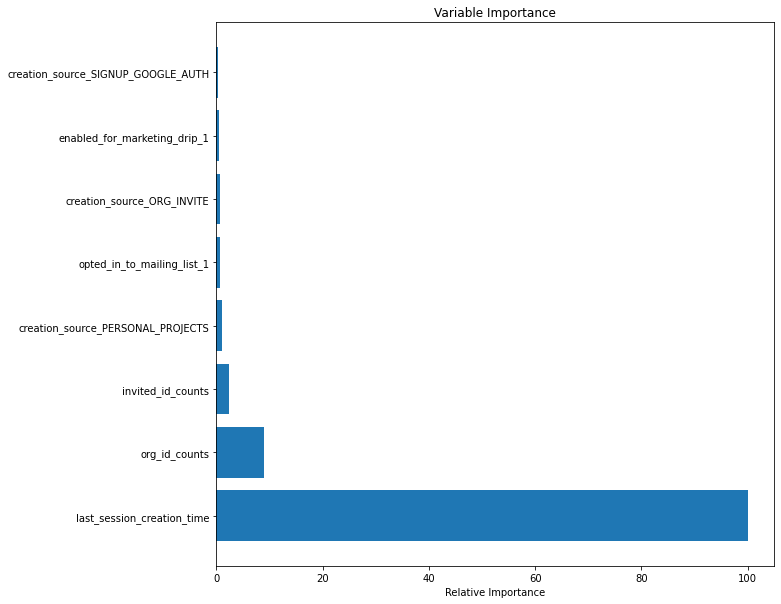

In [122]:
size=8
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
importance_unsorted = pd.DataFrame({'feature':X.columns,'importance':feature_importance})
importance_sorted = importance_unsorted.sort_values(by='importance',ascending=False)
pos = np.arange(size) + .5
plt.figure(figsize=(10,10))
plt.barh(pos, importance_sorted['importance'][:size], align='center')
plt.yticks(pos, importance_sorted['feature'][:size])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The most important feature by far is last session creation time. 